# Generate Climatology Nutrient runoff forcing from GlobalNEWS2 Data

In [1]:
import os
import numpy as np
import pandas as pd
from struct import *
import netCDF4 as nc
from MITgcmutils import mds
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap

In [2]:
import warnings
warnings.filterwarnings("ignore")

## I. Set path to data

In [3]:
# Set parameters
HDlist = os.listdir('/Volumes') 
HDsel = np.nan
HD = ["Proteus","Itsasorantz"]
# HD Selection
while not (HDsel==1 or HDsel==2):
    # While loop Intilization
    if not np.isnan(HDsel):
        print("Wrong choice ! Type 1 or 2")
    # Test Both HD pluged in case    
    if HD[0] in HDlist and HD[1] in HDlist:
        HDsel = int(input("Do you want to read data on (1) Proteus or (2) Itsasorantz ?"))
    # Selection for 1 HD pluged in
    elif HD[0] in HDlist:
        HDsel = 1
    elif HD[1] in HDlist:
        HDsel = 2
print(f"Reading data on {HD[HDsel-1]}")
HDpath = f"/Volumes/{HD[HDsel-1]}/"

Reading data on Itsasorantz


In [4]:
# Set the number of vertical levels
vlvl = 46
# Set the Entry cells distribution (HDist or LDist)
dist = 'HDist'

In [5]:
# params
s2d = 24*3600
Mn = 14.0067
Mp = 30.9738
Msi = 28.0855

In [6]:
DatIn_pth = HDpath+'Data/'
Grd_pth = HDpath+'Modelling/Forcing/grids/G46x68x'+str(vlvl)+'/'
MacIn_pth = HDpath+'Data/ECCO-darwin/delta_inlets/mac270/'
Out_pth = HDpath+'Modelling/Forcing/river_runoff/Nutrients/AGRO_NutClim/r'+str(vlvl)+'/'

## II. Compute fluxes from ArcticGRO Data

### a. Read data

In [7]:
# Read ArcticGRO Samples Data
WQ_df = pd.read_csv(DatIn_pth+'Terr_exports/datasets/ArcticGRO_WatQual_Mackenzie.csv', sep=',', header=8)
WQ_df = WQ_df[['Date','TDN', 'NO3', 'NH4','TDP','PO4', 'SiO2']]
WQ_df = WQ_df[1:].reset_index(drop=True)
# Format df
WQ_df = WQ_df.set_index(pd.DatetimeIndex(WQ_df['Date']))[WQ_df.columns[1:]]
WQ_df = WQ_df.astype(np.float64)
# Compute DON and DOP (g/m3)
WQ_df['DON'] = WQ_df['TDN'] - 1e-3*(WQ_df['NO3']+WQ_df['NH4'])
WQ_df['DOP'] = 1e-3*(WQ_df['TDP'] - WQ_df['PO4'])
WQ_df = WQ_df[['DON','DOP','SiO2']]

### b. Read discharge dataset

In [8]:
# Read ArcticGRO Dicharge Data (m3/s)
Qdf = pd.read_csv(DatIn_pth+'Discharge/ArcticGRO/Mackenzie_Q_reproc.csv', sep=';')
Qdf = Qdf[['date','discharge']]
# Format df
Qdf = Qdf.set_index(pd.DatetimeIndex(Qdf['date']))[Qdf.columns[1:]]
Qdf = Qdf.astype(np.float64)

### c. Compute interannual fluxes

In [9]:
# Compute monthly climatology
WQ_clim = WQ_df.groupby(WQ_df.index.month).mean()
WQ_nb = WQ_df.groupby(WQ_df.index.month).count()

In [10]:
# Compute the daily fluxes (Gg/d)
WQ_step =  pd.DataFrame(index=Qdf.index, columns=WQ_clim.columns)
AGRO_df =  pd.DataFrame(index=Qdf.index, columns=WQ_clim.columns)
for p in ['DON','DOP','SiO2']:
    for y in range(1,13):
        WQ_step.loc[WQ_step.index.month==y, [p]] = WQ_clim.loc[WQ_clim.index==y][p].values[0]
    AGRO_df[p] = WQ_step[p]*Qdf['discharge']*s2d*1e-9
AGRO_df = AGRO_df.astype(np.float64)

In [11]:
date_clim = pd.date_range('2000-01-01','2000-12-31',freq='d')
AGRO_df4c = AGRO_df[AGRO_df.index.year>=2000]
# Compute interannual fluxes
AGRO_clim = AGRO_df4c.groupby([AGRO_df4c.index.month,
                             AGRO_df4c.index.day]).mean().reset_index(drop=True).set_index(date_clim)
AGRO_mth = AGRO_clim.groupby(AGRO_clim.index.month).sum()
AGRO_an = AGRO_df4c.groupby(AGRO_df4c.index.year).sum()

In [12]:
pd.DataFrame(data=np.array([AGRO_an.mean().values]), columns=['DON','DOP','SiO2'])

,DON,DOP,SiO2
0,46.356111,0.840119,1086.364978


## III. Comprae fluxes with Terhaar et al. 2021

### a. Read data

In [13]:
Terh_ds = nc.Dataset(DatIn_pth+'Terr_exports/datasets/terhaar_2021_riverine_fluxes.nc','r')  # kg/s
lon, lat = np.meshgrid(Terh_ds['lon'][:],Terh_ds['lat'][:])
Terh_df =  pd.DataFrame(index=date_clim, columns=['DON','DSi','TDP'])
for p in ['DON','DSi','TDP']:
    for m in range(12):
        Terh_df.loc[Terh_df.index.month==m+1, [p]] = Terh_ds[p][m,158,45]*3600*24*1e-6
Terh_df = Terh_df.astype(np.float64)

In [14]:
# Compute interannual fluxes
Terh_mth = Terh_df.groupby([Terh_df.index.month]).sum()
Terh_an = Terh_df.groupby(Terh_df.index.year).sum()
Terh_an

,DON,DSi,TDP
2000,30.122593,540.310588,2.910454


### b. plot comparison

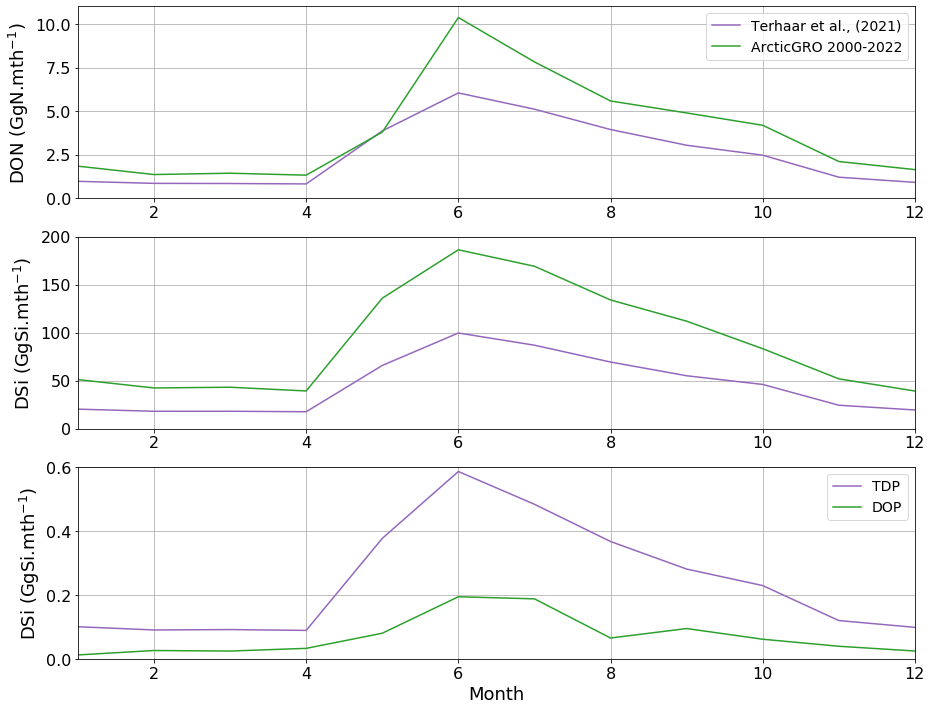

In [15]:
plt.figure(figsize=(15,12))

plt.subplot(311)
#### PLOT ####
plt.plot(Terh_mth['DON'], color='tab:purple', label='Terhaar et al., (2021)')
plt.plot(AGRO_mth['DON'], color='tab:green', label='ArcticGRO 2000-2022')
#### PARAMS ####
plt.grid()
plt.xlim(1,12)
plt.ylim(0,11)
plt.tick_params(labelsize=16)
plt.legend(fontsize=14)
plt.ylabel('DON (GgN.mth$^{-1}$)', fontsize=18)

plt.subplot(312)
#### PLOT ####
plt.plot(Terh_mth['DSi'], color='tab:purple')
plt.plot(AGRO_mth['SiO2'], color='tab:green')
#### PARAMS ####
plt.grid()
plt.xlim(1,12)
plt.ylim(0,200)
plt.tick_params(labelsize=16)
plt.ylabel('DSi (GgSi.mth$^{-1}$)', fontsize=18)

plt.subplot(313)
#### PLOT ####
plt.plot(Terh_mth['TDP'], color='tab:purple', label='TDP')
plt.plot(AGRO_mth['DOP'], color='tab:green', label='DOP')
#### PARAMS ####
plt.grid()
plt.xlim(1,12)
plt.ylim(0,.6)
plt.legend(fontsize=14)
plt.tick_params(labelsize=16)
plt.xlabel('Month', fontsize=18)
plt.ylabel('DSi (GgSi.mth$^{-1}$)', fontsize=18)

plt.show()

## IV. Prepare Forcing

### a. Convert AGRO Load from $Gg.d^{-1}$ to $mmol.s^{-1}$

In [16]:
Ld_df = pd.DataFrame(columns=['DON','DOP','DSi'], index=AGRO_df.index)
Ld_df['DON'] = AGRO_df['DON']*1e12/(Mn*s2d)
Ld_df['DOP'] = AGRO_df['DOP']*1e12/(Mp*s2d)
Ld_df['DSi'] = AGRO_df['SiO2']*1e12/(Msi*s2d)

### b. Read Mac270 grid data

In [17]:
# read mac270 grid
XC = mds.rdmds(Grd_pth+'XC')
YC = mds.rdmds(Grd_pth+'YC')
Vol = mds.rdmds(Grd_pth+'rAc')*mds.rdmds(Grd_pth+'dRF')[0]
print('Size of 1st vertical level = %.i m'%mds.rdmds(Grd_pth+'dRF')[0])
MaskC = mds.rdmds(Grd_pth+'maskInC')
# read mac270 inlets
inlet = np.load(MacIn_pth+'Inlets_'+dist+'.npy')
w = np.load(MacIn_pth+'inletsW_'+dist+'.npy')

Size of 1st vertical level = 3 m


## V. Plot inlet situation

In [18]:
# Setup Mackenzie shelf Situation (Lambert Conformal basemap)
m = Basemap(width=400000,height=360000,projection='lcc',
            resolution='i',lat_1=69.,lat_2=71,lat_0=69.5,lon_0=-135.)
#Coordinates
parallels = np.arange(68.,72,1.)
meridians = np.arange(-141.,-120.,3.)

In [19]:
# Set elements for plot
col = ['tab:orange','tab:blue','tab:green']
Coor = np.array([np.meshgrid([-136.2,-135.4],[68.75,69.05]),np.meshgrid([-135.6,-135],[69.35,69.55]),
                 np.meshgrid([-134.1,-133.4],[69.25,69.5])])

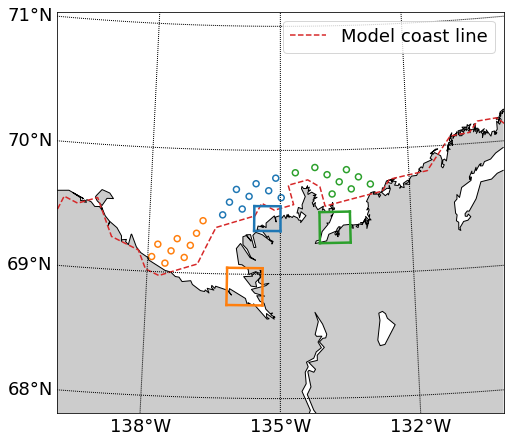

In [20]:
fig = plt.figure(figsize=(8,8))

###  Basemap coast   ###
m.drawcoastlines()
m.fillcontinents(color="#cccccc")
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=18) # (labels = [left,right,top,bottom])
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=18) # (labels = [left,right,top,bottom])
###   Plot Model Coastline   ###
m.contour(XC, YC, MaskC, levels=[0], linestyles="--", colors='tab:red', latlon=True)
plt.legend(fontsize=18, handles=[Line2D([0], [0], color='tab:red',lw=1.5, 
                                        linestyle='--', label='Model coast line')], loc=1)

### Plot inlets ###
for i in range(3):
    ### Inlet Boxes
    m.plot(Coor[i][0],Coor[i][1], col[i], linewidth=2.5, latlon=True)
    m.plot(Coor[i][0].T,Coor[i][1].T, col[i], linewidth=2.5, latlon=True)
    ### Entry point
    id_temp = np.where(inlet==i+1)
    for j in range(len(id_temp[0])):
        m.scatter(XC[id_temp[0][j],id_temp[1][j]], YC[id_temp[0][j],id_temp[1][j]], latlon=True,
                 marker='o', facecolors='none', edgecolors=col[i], linewidths=1.5)

plt.show()

## IV. Create forcing matrixes

$r[mmol.m^{-3}.s^{-1}] = r[mmol.s^{-1}]*W$ 

where $W = \frac{w}{V.N}$ with:
- $w$= Morley (2012) outlet weight
- V = cell volume
- N = Number of entry cells for the outlet

In [21]:
# Create the W matrix
id_inlet = np.where(inlet>0)
N = np.ones(inlet.shape)
for i in range(int(inlet.max())):
    N[np.where(inlet==i+1)] = list(inlet[id_inlet]).count(i+1)
W = w/(Vol*N)
W_exp = np.repeat(np.expand_dims(W,axis=0), len(Ld_df.index),axis=0)

In [22]:
Nut_ls = ['DON', 'DOP', 'DSi']
for i in range(len(Nut_ls)):
    globals()[Nut_ls[i]+'_mac270'] = np.zeros((len(Ld_df.index),XC.shape[0],YC.shape[1]))
    for j in range(len(id_inlet[0])):
        Ld_temp = Ld_df[Nut_ls[i]]
        globals()[Nut_ls[i]+'_mac270'][:,id_inlet[0][j],id_inlet[1][j]] = Ld_temp*W_exp[:,id_inlet[0][j],
                                                                                           id_inlet[1][j]]
del Ld_temp

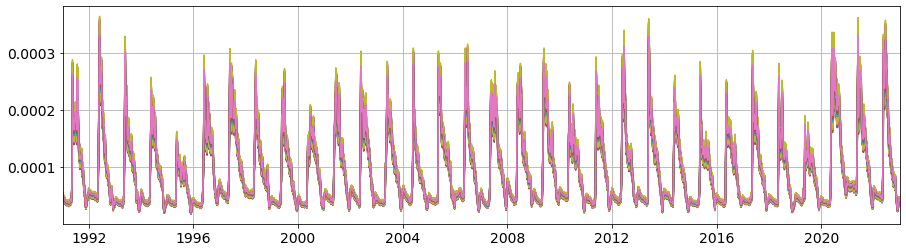

In [23]:
id_inlet = np.where(inlet>0)
plt.figure(figsize=(15,4))
for i in range(len(id_inlet[0])):
    plt.plot(Ld_df.index, DSi_mac270[:,id_inlet[0][i],id_inlet[1][i]])
plt.grid(True)
plt.tick_params(labelsize=14)
plt.xlim(Ld_df.index[0],Ld_df.index[-1])
plt.show()

## V. Save Forcing 

In [24]:
def bin_save(fnm, array):
    newFile = open(fnm, "wb")
    bitearray = pack(">%sf" % len(array.flatten()),*array.flatten())
    newFile.write(bitearray);

### a. Save nutrients climatology forcing matrix

In [25]:
for i in range(len(Nut_ls)):
    if not 't'+Nut_ls[i] in os.listdir(Out_pth+dist+'/'):
        os.mkdir(Out_pth+dist+'/t'+Nut_ls[i]+'/')
    for yr in list(set(Ld_df.index.year)):
        bin_save(Out_pth+dist+'/t'+Nut_ls[i]+"/t"+Nut_ls[i]+"_runoff_mac270_"+str(yr),
                 globals()[Nut_ls[i]+'_mac270'][np.where(Ld_df.index.year==yr)])